# Supervised Learning Classification - Will a given patient require inpatient treatment?

My main learning focusses for this project are:
1. Create a (decent) supervised ML model to predict inpatient treatment, measuring accuracy through:
    - Recall
    - Precision
    - F1 score
    - AUC
2. Utilise chaining in my pandas data exploration and manipulation
3. Logical and clean code that minimises global namespace pollution by utilising functions
4. Utilise best practices for memory efficiency and vectorising for speed when possible 

[DATA LINK](https://www.kaggle.com/datasets/saurabhshahane/patient-treatment-classification)

## Description
### Context
The dataset is Electronic Health Record Predicting collected from a private Hospital in Indonesia. It contains the patients laboratory test results used to determine next patient treatment whether in care or out care patient. The task embedded to the dataset is classification prediction.

### Content
Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: either as a continuous value or as a classification problem.

Name / Data Type / Value Sample/ Description-----------------------------

HAEMATOCRIT /Continuous /35.1 / Patient laboratory test result of haematocrit

HAEMOGLOBINS/Continuous/11.8 / Patient laboratory test result of haemoglobins

ERYTHROCYTE/Continuous/4.65 / Patient laboratory test result of erythrocyte

LEUCOCYTE/Continuous /6.3 / Patient laboratory test result of leucocyte

THROMBOCYTE/Continuous/310/ Patient laboratory test result of thrombocyte

MCH/Continuous /25.4/ Patient laboratory test result of MCH

MCHC/Continuous/33.6/ Patient laboratory test result of MCHC

MCV/Continuous /75.5/ Patient laboratory test result of MCV

AGE/Continuous/12/ Patient age

SEX/Nominal – Binary/F/ Patient gender

SOURCE/Nominal/ {in,out}/The class target in.= in care patient, out = out care patient


# Extra Notes to add somewhere
- in reality, we rarely treat the number, we treat the patient! Patient could be classified as having values on the cusp of inpatient, but considering cost-benefit, we may still discharge.

# Limitations of method
- this is cross-sectional data which takes a single snapshot of a limited array of blood results -> in reality, we want to focus on how results are trending, esp compared to baseline


# IMPORTS AND OPTIONS

In [169]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

pd.options.display.width = 0

# TWEAKS

In [113]:
df = pd.read_csv('data-ori.csv')

def tweak_data(df):
    df = (df
        .astype({'SOURCE':'category', 'SEX':'category'}) # decreased memory usage from ~390kb to 319kb
    )
    return df

df = tweak_data(df)


display(df.head())
display(df.describe())
display(df.info())

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HAEMATOCRIT   4412 non-null   float64 
 1   HAEMOGLOBINS  4412 non-null   float64 
 2   ERYTHROCYTE   4412 non-null   float64 
 3   LEUCOCYTE     4412 non-null   float64 
 4   THROMBOCYTE   4412 non-null   int64   
 5   MCH           4412 non-null   float64 
 6   MCHC          4412 non-null   float64 
 7   MCV           4412 non-null   float64 
 8   AGE           4412 non-null   int64   
 9   SEX           4412 non-null   category
 10  SOURCE        4412 non-null   category
dtypes: category(2), float64(7), int64(2)
memory usage: 319.2 KB


None

# Preliminary notes

There are 4412 rows with 10 predictor variables.

`LEUCOCYTE` seems to be quite positively skewed.

Inpatients make up 40.44%% of the total values for `SOURCE`.

In [114]:
# check distribution of continuous variables
continuous = df.drop(columns=['SEX','SOURCE']).melt()
(px
.box(continuous, y='value', facet_col='variable')
.update_yaxes(matches=None)
.show())

In [115]:
# check distribution of discrete variables
def show_discrete_distribution(df):

    discrete = (df[['SEX','SOURCE']]
    .melt()
    .groupby(['variable'])
    ['value'].value_counts()
    .reset_index(name='count')
    )

    discrete['pct'] = 100* discrete['count'] / discrete.groupby(['variable'])['count'].transform('sum')

    fig = px.histogram(discrete, x="variable", y="pct",
                color='value', 
                barmode='group',
                title='Distribution of `SEX` and `SOURCE`'
                )


    return discrete, fig

show_discrete_distribution(df)[1].show()
show_discrete_distribution(df)[0]

,variable,value,count,pct
0,SEX,M,2290,51.903898
1,SEX,F,2122,48.096102
2,SOURCE,out,2628,59.564823
3,SOURCE,in,1784,40.435177


# Label Encoding and Scaling

Categorical variables can be simply turned into binary

- MALE = 1
- Inpatient = 1

Scaled continuous variables using minmax scaling.

In [116]:
# label encoder


# select the continuous variables for minmax scaling
continuous = df.select_dtypes(include=['int64','float64'])

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(continuous)

norm_df = pd.DataFrame(scaled_data, columns=continuous.columns).assign(SEX=df.SEX.values, SOURCE=df.SOURCE.values)

# label encoding
norm_df = norm_df.replace({
    'F':0,
    'M':1,
    'out':0,
    'in':1
})

display(norm_df.head())
norm_df.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,0.386980,0.529801,0.496865,0.068874,0.257021,0.405405,0.584615,0.349026,0.0,0,0
1,0.538879,0.728477,0.612853,0.153642,0.277447,0.486486,0.615385,0.433442,0.0,0,0
2,0.358047,0.496689,0.510972,0.160265,0.252766,0.343629,0.592308,0.271104,0.0,0,0
3,0.459313,0.655629,0.548589,0.124503,0.304681,0.486486,0.692308,0.397727,0.0,0,0
4,0.311031,0.403974,0.431034,0.278146,0.276596,0.328185,0.461538,0.308442,0.0,1,0


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,0.442996,0.592167,0.479821,0.100909,0.212361,0.514853,0.564849,0.496963,0.465576
std,0.108043,0.137742,0.122898,0.066875,0.096998,0.103191,0.094513,0.111349,0.221747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.373870,0.503311,0.401254,0.060596,0.153191,0.474903,0.515385,0.446429,0.285714
50%,0.450271,0.602649,0.484326,0.086093,0.211064,0.532819,0.569231,0.509740,0.469388
75%,0.520796,0.688742,0.559561,0.121854,0.266383,0.575290,0.623077,0.563312,0.642857
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train Test Split

In [142]:
X = norm_df.drop(columns=['SOURCE'])
y = norm_df['SOURCE']
random_state=1

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

# No major changes, LogisticRegression and DecisionTree models

Around 70% accuracy

Thrombocyte and Leucocyte held the highest weighting in the Logistic Regression

In [ ]:
this is a test

this is another test

Score for LogisticRegression(random_state=1) is 0.7061933534743202
Score for DecisionTreeClassifier(max_depth=4, random_state=1) is 0.7212990936555891
-6.07334171367522 : THROMBOCYTE
-2.0400863400074263 : HAEMOGLOBINS
-1.6676220181417905 : HAEMATOCRIT
-1.546869185291802 : ERYTHROCYTE
-0.8346215646699082 : MCV
-0.6242063193925431 : MCH
0.3327997360835717 : AGE
0.5057658891758752 : SEX
0.5758947511020513 : MCHC
4.079353935711432 : LEUCOCYTE


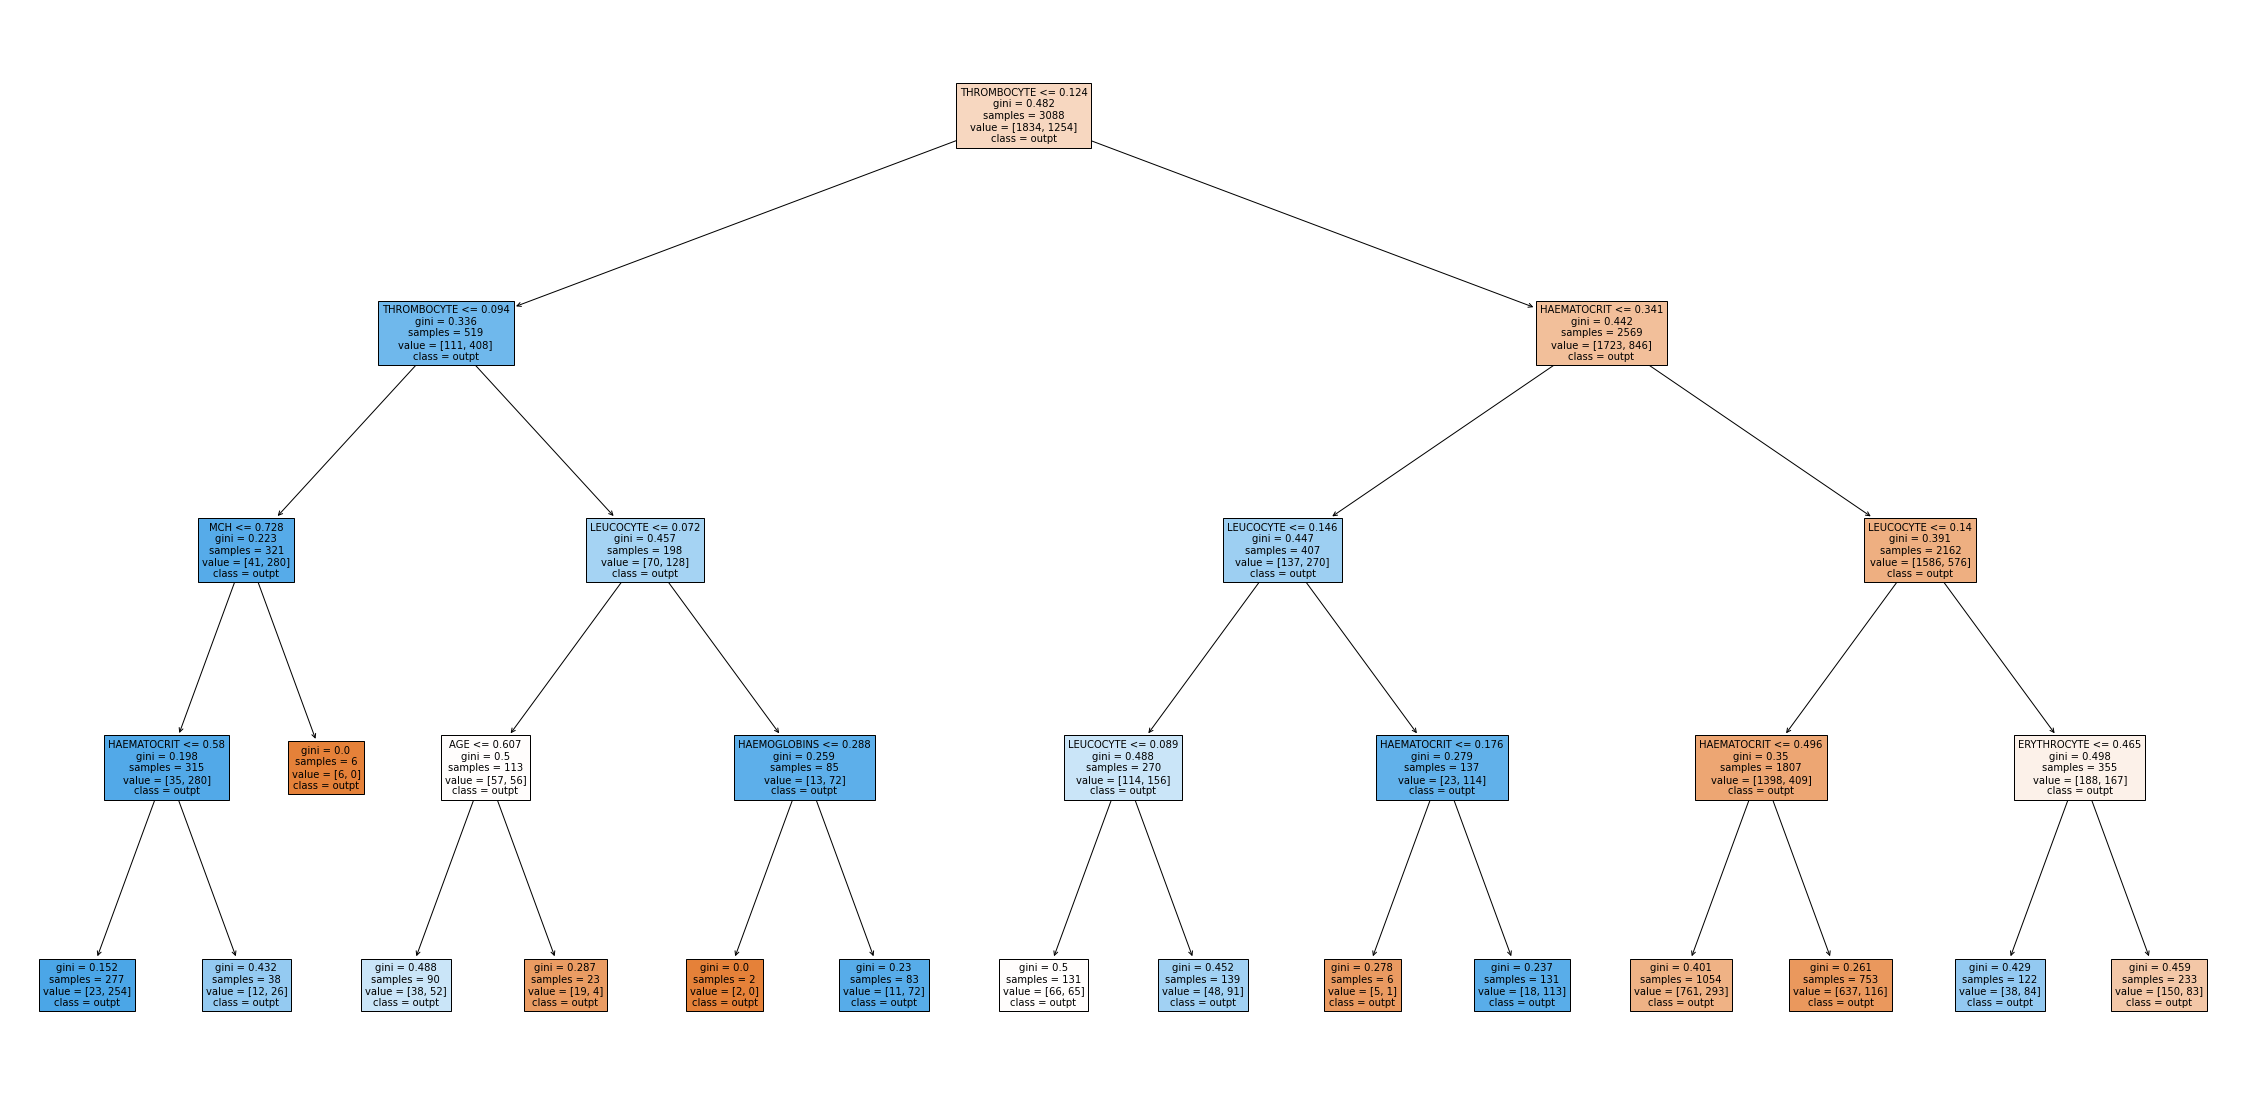

In [196]:
random_state=1
lr = LogisticRegression(random_state=1)
dt = DecisionTreeClassifier(random_state=1,
max_depth=4
)

lr.fit(x_train, y_train)
dt.fit(x_train,y_train)

for model in [lr, dt]:
    print(f"Score for {model} is {model.score(x_test, y_test)}")

# show regression coefficients
reg_coefficients = {coef:feat for coef,feat in zip(lr.coef_.tolist()[0], lr.feature_names_in_.tolist())}
for coef in sorted(reg_coefficients):
    print(f"{coef} : {reg_coefficients[coef]}")

# show tree
def make_tree_plot(dt, col_names):
    fig = plt.figure(figsize=(40,20))
    _ = tree.plot_tree(dt,
    feature_names=col_names,
    class_names=y.map({0:'outpt', 1:'inpt'}),
    filled=True,
    fontsize=10)
make_tree_plot(dt, X.columns)

# Correlations

Can we remove any features by looking at correlation?

These are all blood product measurements so the high co-linearity of the following variables makes sense:
- Hb (Haemoglobins) and Haematocrit -> keep Hb
- RBC (Erythrocyte) and Haematocrit -> both removed
- RBC and HB -> keep Hb
- MCV and MCH -> keep MCV

Based on correlation with target (noting that none of the individually correlate very well), the following variables are dropped;
- Haematocrit
- Erythrocyte
- MCH

Running the logisticReg and decisionTrees again with 3 fewer features, we see that there's been no significant impact on accuracy which is good as fewer inputs required and increased reliability of model performance on real world data!

On the correlations themselves:
- Age and Leucocytes (white cells which increase in response to infection/inflammation) positively correlate inpatient stay
    - Older people require more care -> perhaps due to increase co-morbidities and fraility
    - Increased white cells indicate on-going infection -> worried about ?sepsis so more likely to keep these patients in
- Thrombocytes are negatively correlated with inpatient stay
    - Thrombocytes are raised following acute blood loss, infections, or blood clots

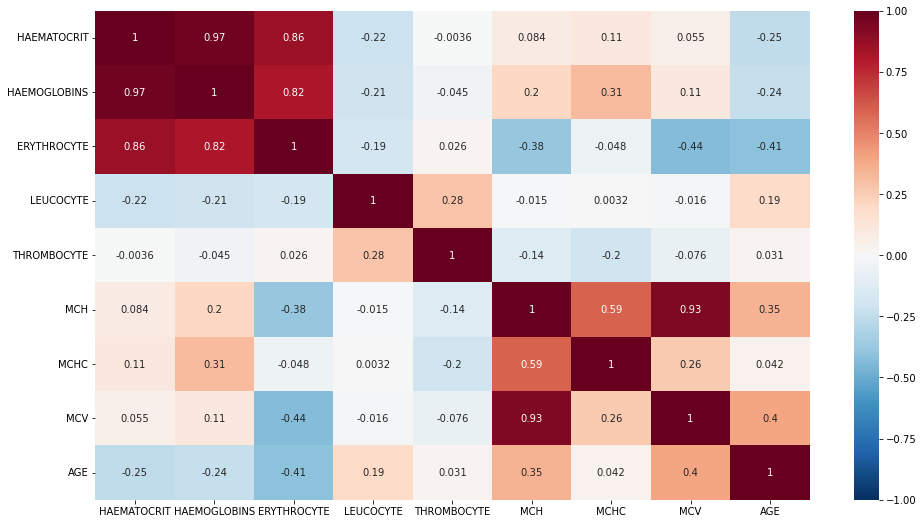

Score for LogisticRegression(random_state=1) is 0.7061933534743202
Score for DecisionTreeClassifier(max_depth=5, random_state=1) is 0.7122356495468278


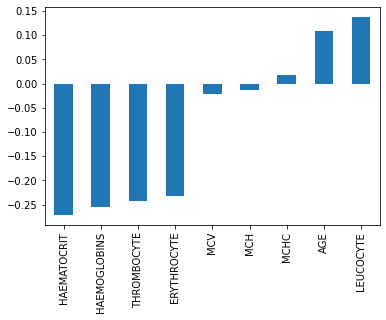

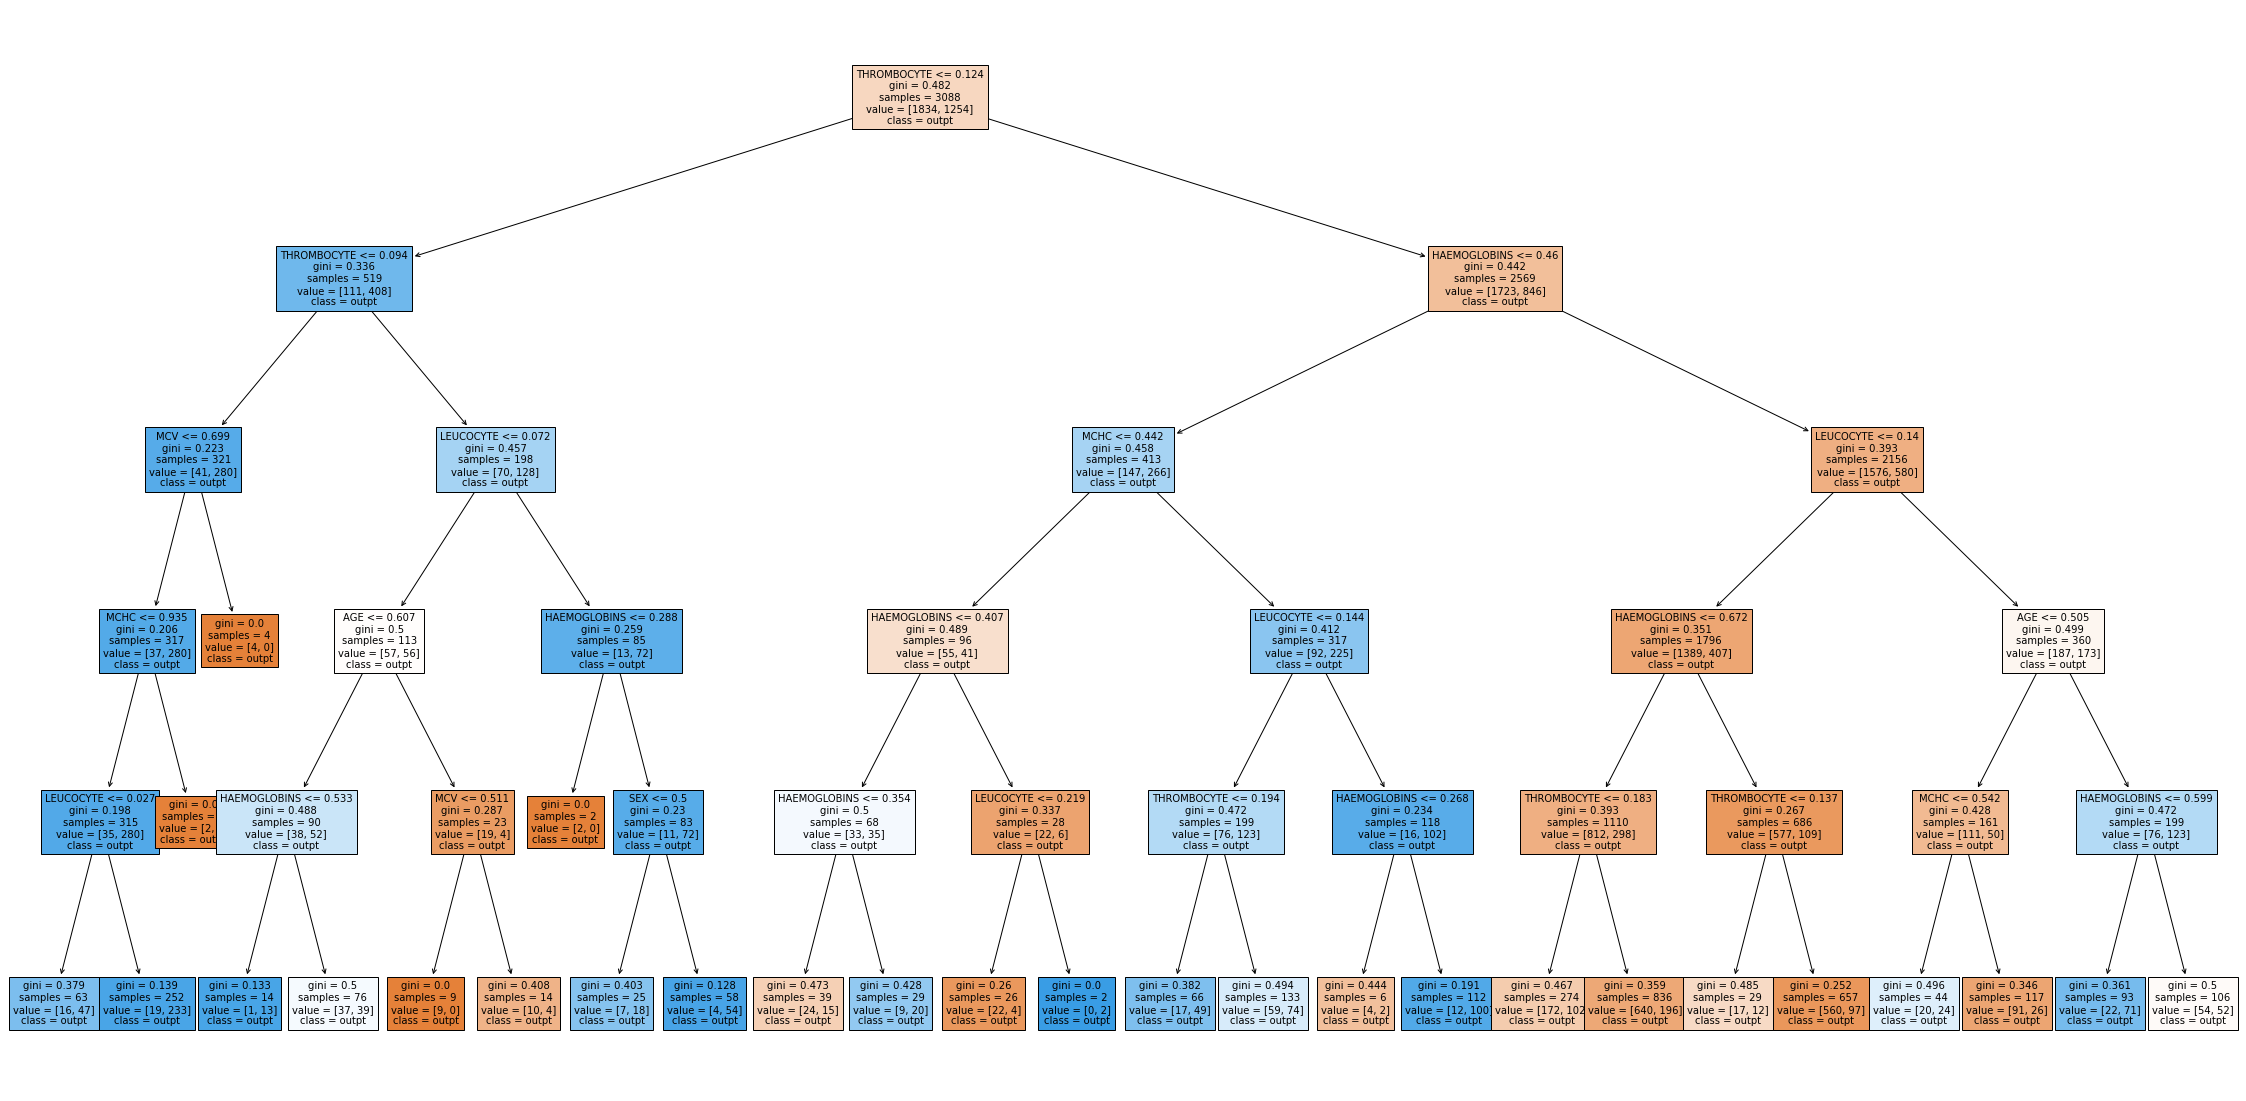

In [181]:
# between predictors
corr_matrix = X.corr(method='pearson')  # 'pearson' is default 
plt.figure(figsize = (16,9))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.show()

# corr with target
(norm_df
.corrwith(norm_df['SOURCE'])
.sort_values()
.plot(kind='bar'))

x_train_best_corr = x_train.drop(columns=['HAEMATOCRIT','ERYTHROCYTE','MCH'])
x_test_best_corr = x_test.drop(columns=['HAEMATOCRIT','ERYTHROCYTE','MCH'])

random_state=1
lr = LogisticRegression(random_state=1)
dt = DecisionTreeClassifier(random_state=1, max_depth=5)

for model in [lr, dt]:
    model.fit(x_train_best_corr, y_train)
    print(f"Score for {model} is {model.score(x_test_best_corr, y_test)}")

make_tree_plot(dt, col_names=x_train_best_corr.columns)